In [1]:
import os
import cv2
import time
import xlrd 
import h5py
import keras
import numpy as np
import scipy.ndimage
import pydicom as dicom
import matplotlib.pyplot as plot
from ipywidgets import IntProgress
from keras.models import Sequential
from tqdm.notebook import tqdm as tq
from keras.utils import to_categorical
from skimage import measure,morphology,segmentation
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [2]:
# Function to load a patient CT Scan
input_patient_path = 'D:/Study Materials/My Projects/cancer/LUNG CT SCAN DATASET/SPIE-AAPM Lung CT Challenge/Train/CT-Training-BE001'
def load_patient_CT_scan(input_patient_path):
    
    # loading dicom file of a patient
    dicom_lung_slices = [dicom.read_file(os.path.join(input_patient_path,dicom_lung_slice)) for dicom_lung_slice in os.listdir(input_patient_path)]
    # sorting dicom slices w.r.t the 'Instance Number'
    dicom_lung_slices.sort(key=lambda x : int(x.InstanceNumber))
    # extracting image array from the dicom slices
    lung_image_slices = np.stack([dicom_lung_slice.pixel_array for dicom_lung_slice in dicom_lung_slices])
    
    return dicom_lung_slices , lung_image_slices

In [3]:
# Function to Convert the lung image to Hounsfield Units (HU)
def convert_img_hu(dicom_lung_slices , lung_image_slices):
    
    # Converting the image array to int16 
    lung_image_slices = lung_image_slices.astype(np.int16)
    
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    lung_image_slices[lung_image_slices == -2000] = 0
    
    # Converting the image array to Hounsfield Units (HU)
    for slice_count in range(len(dicom_lung_slices)):
        
        # Obtaining Rescle Slope and Intercept from the dicom slices
        slope = dicom_lung_slices[slice_count].RescaleSlope
        intercept = dicom_lung_slices[slice_count].RescaleIntercept
        
        # Applying Slope and Intercept value to convert into HU
        if slope != 1:
            lung_image_slices[slice_count] = slope * lung_image_slices[slice_count].astype(np.float64)
            lung_image_slices[slice_count] = lung_image_slices[slice_count].astype(np.int16)
            
        lung_image_slices[slice_count] += np.int16(intercept)
    
    return np.array(lung_image_slices, dtype=np.int16)

In [4]:
# Function to Convert the lung image from Hounsfield Units (HU) to original
def convert_img_hu_to_original(dicom_lung_slices , lung_image_slices_hu_reshaped):
    
    # Converting the image array to int16 
    lung_image_slices_hu_reshaped = lung_image_slices_hu_reshaped.astype(np.int16)
    
    
    
    # Converting the image array to Hounsfield Units (HU)
    for slice_count in range(len(dicom_lung_slices)):
        
        # Obtaining Rescle Slope and Intercept from the dicom slices
        slope = dicom_lung_slices[slice_count].RescaleSlope
        intercept = dicom_lung_slices[slice_count].RescaleIntercept
        
        # Applying Slope and Intercept value to convert into HU
        if slope != 1:
            lung_image_slices_hu_reshaped[slice_count] = slope / lung_image_slices_hu_reshaped[slice_count].astype(np.float64)
            lung_image_slices_hu_reshaped[slice_count] = lung_image_slices_hu_reshaped[slice_count].astype(np.int16)
            
        lung_image_slices_hu_reshaped[slice_count] -= np.int16(intercept)
    
    return np.array(lung_image_slices_hu_reshaped, dtype=np.int16)

In [5]:
# Function to resample the image array into uniform spacing (1,1,1)
def resample_lung_img(dicom_lung_slices , lung_image_slices_hu, new_spacing = [1,1,1]):
    
    # Obtaining the current spacing of the image array from the dicom slices
    slice_thickness = [dicom_lung_slices[0].SliceThickness] #slice thickness
    slice_pixel_spacing = dicom_lung_slices[0].PixelSpacing #Slice pixel spacing
    
    # Merging  SliceThickness and PixelSpacing into a list
    slice_thickness.extend(slice_pixel_spacing) 
    
    # Converting spacing to float32
    current_spacing= np.array(slice_thickness, dtype=(np.float32))
    
    
    # Calculating reshape factor
    reshape_factor = current_spacing / new_spacing
    new_img_shape = reshape_factor * lung_image_slices_hu.shape
    rounded_img_shape = np.round(new_img_shape)
    
    # shape cannot be in float so rounding the shape and 
    # obtaing the updated reshape factor
    actual_reshape_factor = rounded_img_shape / lung_image_slices_hu.shape
    new_spacing = current_spacing / actual_reshape_factor
    
    # Interpolating image array to resample to spacing (1, 1, 1)
    lung_image_slices_hu = scipy.ndimage.interpolation.zoom(lung_image_slices_hu, actual_reshape_factor, mode='nearest')
    
    
    return  lung_image_slices_hu, new_spacing


In [15]:
def largest_label_volume(im, bg=-1):
    # get the unique values and their no of occurence(count) in the image
    vals, counts = np.unique(im, return_counts=True)

    # removing the counts which have 'value' equal to 'bg'
    counts = counts[vals != bg]
    # removing the values which have 'value' equal to 'bg'
    vals = vals[vals != bg]

    # obtaining the indexes which have max count/ occurence in the image
    if len(counts) > 0:
        
        # keeping the 'values' which have max occurences with the help of 'counts'
        return vals[np.argmax(counts)]
    else:
        return None
    
# this function gets the lungs segmented by forming a lung mask and
# multiply the mask with the image
def segment_lung_mask(image, fill_lung_structures=True):
    
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want as 'measure.label' has background = 0 as default
    binary_image = np.array(image > -420, dtype=np.int8)+1
    
    # labels the binary mask 
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    # since the trays blocks the connectivity of the air above it 
    # therefore label values for upward air is not equal to the labeled values of air below the tray  
    background_label = labels[0,0,0]
    
    # Fill the air 'above the tray' around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        # 'for loop' is used because if we label the whole 3D image then 
        # the largest area would be the lungs
        for i, axial_slice in enumerate(binary_image):
            # converting it to 0,1 as 0 values are treated 
            # as background for 'measure.label' function
            axial_slice = axial_slice - 1 
            # labelling the areas except the lungs
            labeling = measure.label(axial_slice)
            # getting the label which has the highest no. of counts
            l_max = largest_label_volume(labeling, bg=0)
            
            # applying 1 to the labeled values which no. of counts is not the highest
            # This will make the nodules value the same as the lung value i.e 1
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    # the motive is to label all the areas including air pockets
    # and then obtain the lung area using 'largest_label_volume' function
    # and then remove other areas  from the binary image which are not lung areas 
    # those are air pockets
    labels = measure.label(binary_image, background=0)
    plot.imshow(binary_image[80],cmap=plot.cm.bone)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
    
        
    return binary_image


In [16]:
# Function to resize the image

def resize_voxel(Image3D,size=(100,100)):
    resized_image = []
    for i in range(len(Image3D)):
        resized_image.append(cv2.resize(Image3D[i],size))
        
    return np.asarray(resized_image,dtype=np.int16)

In [17]:
Train_Patients_Path = "D:/Study Materials/My Projects/cancer/LUNG CT SCAN DATASET/SPIE-AAPM Lung CT Challenge/Train/"
Train_Patients = os.listdir(Train_Patients_Path)
Save_Path = "D:/Study Materials/My Projects/cancer/LUNG CT SCAN DATASET/SPIE-AAPM Lung CT Challenge/Preprocessed_Train_Data/"

In [18]:
# Function to take 100 slices w.r.t the nodule center image 
def crop_cube(image,Nodule_Location,cube_size = 100):
    image_shape = image.shape
    upper_z = Nodule_Location - (cube_size//2)
    lower_z = Nodule_Location + (cube_size//2)
    if(upper_z < 0):
        upper_z = 0
        lower_z = upper_z + cube_size
    elif(lower_z > image_shape[0]):
        lower_z = image_shape[0]
        upper_z = lower_z - cube_size
           
    image = image[upper_z:lower_z]
    
    return np.array(image,dtype=np.int16)

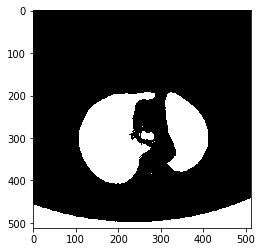

In [21]:
# Nodule Cube Size
Nodule_cube_size = 100

# Calculating the maximum no. of slice a patient has.
# max_slices = np.max([len(slices) for slices in [os.listdir(Train_Patients_Path + Patients) for Patients in Train_Patients]])

# Loading the 'Nodule_locations' from xlsx file provided
xlsx_path = ("D:/Study Materials/My Projects/cancer/LUNG CT SCAN DATASET/CalibrationSet_NoduleData.xlsx") #Xlsx label path 
wb = xlrd.open_workbook(xlsx_path) #opening the workbook(xlsx file)
sheet = wb.sheet_by_index(0) 

# Extracting the 'Nodule_locations' 
Nodule_locations_list = [[sheet.cell_value(i, 0) ,  int(sheet.cell_value(i, 1))] for i in range(1,11)]



for patients_nodules in tq(Nodule_locations_list[:1],desc="Progress"):
    patients = patients_nodules[0] #PatientName
    nodule_location = patients_nodules[1] #Patient'sNoduleCenterImage
    # loading patient dicoms
    dicom_lung_slices , lung_image_slices = load_patient_CT_scan(Train_Patients_Path + patients)
    plot.imshow(lung_image_slices[80],cmap=plot.cm.bone)
    plot.savefig('Original_image_2.png',dpi=1200)
    # converting image to Hounsfield Units (HU)
    lung_image_slices_hu = convert_img_hu(dicom_lung_slices , lung_image_slices)
    # segmenting the lung nodules
    
    segmented_lungs = segment_lung_mask(lung_image_slices_hu, False)
    segmented_lungs_fill = segment_lung_mask(lung_image_slices_hu, True)
    # converting back to original pixel value
    lung_image_slices = convert_img_hu_to_original(dicom_lung_slices , lung_image_slices_hu)
    # Applying segmented Nodule mask with actual image
    image_3D_Nodules = (segmented_lungs_fill-segmented_lungs) * lung_image_slices
    # Taking 100 slices w.r.t nodule center image location 
    nodule_cube = crop_cube(image_3D_Nodules,nodule_location, Nodule_cube_size)
    # Resampling the image array to spacing(1,1,1)
    nodule_cube_resampled,new_spacing = resample_lung_img(dicom_lung_slices , nodule_cube, new_spacing = [1,1,1])
    # resized the image array to (* ,100,100)
    nodule_cube_resampled = resize_voxel(nodule_cube_resampled,size=(100,100))
    # checking the image shape
    image_shape = list(nodule_cube_resampled.shape)
    
    # extracting the no of slices 
    #image_shape[0] = max_slices -image_shape[0]
    # preparing additional slices for padding
    #slice_extend = np.zeros(image_shape, dtype=np.int16)
    # adding the padding to the image to maake all the patient images uniform
    #extended_image = np.concatenate((image_3D_Nodules, slice_extend)) 
   
    # Saving the result as npy 
    #np.save(Save_Path+patients+".npy",nodule_cube_resampled)
    
    
    


In [ ]:
# ----Preparatory code ----
# Model configuration
batch_size = 2
no_epochs = 30
learning_rate = 0.001
no_classes = 2
validation_split = 0.2
verbosity = 1
sample_shape = (100,100,100,1)

In [ ]:
# Manipulating the data to feed into the model

# Loading the labels from xlsx file provided
xlsx_path = ("D:/Study Materials/My Projects/cancer/LUNG CT SCAN DATASET/CalibrationSet_NoduleData.xlsx") #Xlsx label path 
wb = xlrd.open_workbook(xlsx_path) #opening the workbook(xlsx file)
sheet = wb.sheet_by_index(0) 

# Extracting the labels and set malignant to 1 and benign to 0
labels = np.array([[sheet.cell_value(i, 0) , 1 if sheet.cell_value(i, 3)=='malignant' else 0 ] for i in range(1,11)])
labels = np.sort(labels,axis = 0) #sorted the list row-wise
Patient_numpy=[] # Creating empty list

# Loading the patients numpy data and adding its label taking the 'patient names' and 'labels' from the Label array
Patient_numpy=np.array([[np.load(Save_Path+labels[i][0]+'.npy'),int(labels[i][1])] for i in range(len(labels))])

# Splitting data into 80% training and 20% testing
Train = np.append(Patient_numpy[:3],Patient_numpy[5:8],axis=0)
Test = [Patient_numpy[4],Patient_numpy[9]]
Validation = [Patient_numpy[3],Patient_numpy[8]]

# Separating Train Data,Train Labels and Test Data, Testy Labels
Train_data = [Train[i][0] for i in range(len(Train))]
Test_data = [Test[i][0] for i in range(len(Test))]
Validation_data = [Validation[i][0] for i in range(len(Validation))]

Train_labels = [Train[i][1] for i in range(len(Train))]
Test_labels = [Test[i][1] for i in range(len(Test))]
Validation_labels = [Validation[i][1] for i in range(len(Validation))]

# One_Hot_Encoding the Training and Testing Labels
Train_labels = to_categorical(Train_labels).astype(np.integer)
Test_labels = to_categorical(Test_labels).astype(np.integer)
Validation_labels = to_categorical(Validation_labels).astype(np.integer)

# Estimating the shape of the Training Data and Testing Data that can be fed into the CNN 
Train_data_shape = (np.shape(Train_data)[0],np.shape(Train_data)[1],np.shape(Train_data)[2],np.shape(Train_data)[3],1)
Test_data_shape = (np.shape(Test_data)[0],np.shape(Test_data)[1],np.shape(Test_data)[2],np.shape(Test_data)[3],1)
Validation_data_shape = (np.shape(Validation_data)[0],np.shape(Validation_data)[1],np.shape(Validation_data)[2],np.shape(Validation_data)[3],1)


# Reshaping the Training Data and Testing Data according to to model need
Train_data = np.array(Train_data,dtype=np.int16).reshape(Train_data_shape)
Test_data = np.array(Test_data,dtype=np.int16).reshape(Test_data_shape)
Validation_data = np.array(Validation_data,dtype=np.int16).reshape(Validation_data_shape)
print(Train_data.shape,Test_data.shape,Validation_data.shape)

In [ ]:
# Create the model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

In [ ]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

# Fit data to model
history = model.fit(Train_data, Train_labels, batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_data=(Validation_data, Validation_labels))

In [ ]:
# Generate generalization metrics
score = model.evaluate(Test_data, Test_labels, verbose=0)
print(f'Test loss: {score[0]} | Test accuracy: {score[1]}')

# Plot history: Categorical crossentropy & Accuracy
plot.plot(history.history['loss'], label='Categorical crossentropy (training data)')
plot.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
plot.plot(history.history['accuracy'], label='Accuracy (training data)')
plot.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plot.title('Model performance for 3D MNIST Keras Conv3D example')
plot.ylabel('Loss value')
plot.xlabel('No. epoch')
plot.legend(loc="upper right")
plot.show()